# H1.0 orthologs
The purpose of this experiment is to structurally characterise H1.0 orthologs across eukaryotes

In [1]:
# Imports
import requests
import pandas as pd
import json
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
import mdtraj as md
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

sys.path.append('../../src')
import data_utils
import analyse_utils

## Data preparation

### Quering orthologs from OrthoDB

API-documentation: https://www.ezlab.org/orthodb_userguide.html#api

Ortho DB groups:
- [histone H1.0](https://www.orthodb.org/?query=19111at9604)
    - 5363206at2759 at Eukaryota level
    - 2491618at33208 at Metazoa level
    - 1590200at7742 at Vertebrata level
    - 1033145at32523 at Tetrapoda level
    - 21759at40674 at Mammalia level
    - 97195at9347 at Eutheria level
    - 97195at314146 at Euarchontoglires level
    - 97195at9443 at Primates level
    - 19111at314295 at Hominoidea level (1)
    - 19111at9604 at Hominidae level (2)

In [ ]:
# Querying API
group = '5363206at2759'
url = f"https://data.orthodb.org/current/orthologs?id={group}"
response = requests.get(url).json()

In [ ]:
# Saving to metadata
with open('H1-0_orthodb.json', 'w') as file:
    json.dump(response, file, indent=4)

### Templates

In [3]:
# Extracting entries from OrthoDB
with open('H1-0_orthodb.json') as file:
    data = json.load(file)

# Extracting UniProt IDs
uids = []
uids_species = []
no_uids_ids = []
no_uids_species = []
for id in range(len(data['data'])):

    # Skipping species without UniProt entries
    try:
        for protein in data['data'][id]['genes']:
            uids.append(protein['uniprot']['id'])
            uids_species.append(data['data'][id]['organism']['name'])
    except KeyError:
        no_uids_ids.append(data['data'][id]['genes'][0]['gene_id']['param'])
        no_uids_species.append(data['data'][id]['organism']['name']) 

# Handling proteins with no UniProt IDs
if no_uids_species:
    print(f"The following {len(no_uids_species)}/{len(data['data'])} entries had no UniProt IDs")
    print(*[f" - {specie}" for specie in no_uids_species], sep="\n")

# Defining UniProt IDs
templates = pd.DataFrame({'uniprot_id': uids,
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None})

The following 319/485 entries had no UniProt IDs
 - Cyprinodon tularosa
 - Gambusia affinis
 - Girardinichthys multiradiatus
 - Nematolebias whitei
 - Poecilia formosa
 - Poecilia reticulata
 - Xiphophorus hellerii
 - Archocentrus centrarchus
 - Simochromis diagramma
 - Acanthopagrus latus
 - Alosa alosa
 - Alosa sapidissima
 - Anarrhichthys ocellatus
 - Anguilla anguilla
 - Boleophthalmus pectinirostris
 - Cheilinus undulatus
 - Chelmon rostratus
 - Colossoma macropomum
 - Coregonus clupeaformis
 - Cyclopterus lumpus
 - Cyprinus carpio
 - Denticeps clupeoides
 - Echeneis naucrates
 - Electrophorus electricus
 - Epinephelus lanceolatus
 - Erpetoichthys calabaricus
 - Etheostoma cragini
 - Etheostoma spectabile
 - Gadus morhua
 - Gasterosteus aculeatus aculeatus
 - Gouania willdenowi
 - Hippoglossus hippoglossus
 - Hippoglossus stenolepis
 - Hypomesus transpacificus
 - Lates calcarifer
 - Lepisosteus oculatus
 - Megalobrama amblycephala
 - Megalops cyprinoides
 - Micropterus dolomieu
 -

In [4]:
# Collecting metadata
deleted_records = []
for id, row in templates.iterrows():
    try:
        name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    except:
        deleted_records.append(id)
        continue
    templates.loc[id] = {
            'uniprot_id': row.uniprot_id,
            'name': name,
            'description': desc,
            'species': spec,
            'sequence': seq}
    
# Discarding deleted UniProt records
if deleted_records:
    print(f"The following {len(deleted_records)}/{len(templates)} UniProt IDs returned no records:")
    for id in deleted_records:
        print(f" - {templates.loc[id].uniprot_id}")
    templates.drop(index=deleted_records, inplace=True)

The following 4/199 UniProt IDs returned no records:
 - A0A5F4D9L8
 - G3W6X3
 - A0A6I9JUI2
 - A0A1L8GP11


Some hits from the BLAST are irrelevant, as they are most likely not orthologs, like:
- "Uncharacterized protein"
- "8-amino-7-oxononanoate synthase-like"

Additionally, some hits are more subtle orthologs, like other members of the H15 superfamily:
- "H5 protein"
- "H15 domain-containing protein"

Lastly, some are in a grey area of  the H1.0 definition:
- "histone H1.0-like"
- "Histone H1.0-B"
- "histone H1.0-B-like"
- "H1 histone family, member 0"

This section is used to specify the names of the orthologs to be used for analysis

In [11]:
# Finding all unique descriptions / names
templates['description'].value_counts()

histone H1.0                               37
Histone H1.0                               30
H1.0 linker histone                        28
Histone H1.0-B                             22
H15 domain-containing protein              17
Histone H5                                 11
histone H1.0-like                          11
histone H1.0-B                              6
Histone H1.0-B-like                         6
Linker histone H1 and H5 family protein     5
Histone H1.0-like                           3
histone H5                                  3
histone H1.0-B-like                         2
late histone H1-like                        2
H1 histone family, member 0 like 1          1
H1 histone family member 0 like protein     1
8-amino-7-oxononanoate synthase-like        1
Putative histone h1.0                       1
Uncharacterized protein                     1
H1F0 isoform 1                              1
Histone H1-beta, late embryonic             1
Histone H1                        

In [12]:
# Setting description requirements
required  = ['H1', 'h1', 'H5', 'h5']

# Filtering off
filtered = templates[templates.apply(lambda row: max([req in row['description'] for req in required]), axis=1)]

# Displaying proteins that were filtered off
templates.loc[list(set(templates.index) - set(filtered.index))]

,uniprot_id,name,description,species,sequence
74_9SAUR,A0A6I9XPX0,A0A6I9XPX0_9SAUR,8-amino-7-oxononanoate synthase-like,Thamnophis sirtalis,MWCSQFFRSPFVLGQCSPSRAQSALAQLKHLLEGELEGIRGAGTWK...
190_CAEBR,A8Y2Z3,A8Y2Z3_CAEBR,Protein CBG22701,Caenorhabditis briggsae,MHCFAITPTPEGSPAPEDSPVAAQTTPKRPAATPAKARKAKRGPGR...
109_SHEEP,A0A6P3E3Z9,A0A6P3E3Z9_SHEEP,Uncharacterized protein,Ovis aries (Sheep),MTENSTSTPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...


In [13]:
# Setting IDs from integer range and UniProt name
templates.reset_index(inplace=True)
templates.index = templates.index.astype(str) + '_' + templates.name.map(lambda n: n.split('_')[-1])

In [10]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('ortho_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### IDRs

In [2]:
# Getting template metadata
with open('ortho_h1-0.json', 'r') as file:
    metadata = json.load(file)

In [3]:
# Getting CTD
length_order=False
i_idr=-1
region_filter = ['CTD']

In [4]:
# Getting IDR regions
IDRs = []
not_IDP = []
for id, fields in metadata['templates'].items():
    try:
        seq, loc, reg = data_utils.get_protein_idr(uniprot_id=fields['uniprot_id'], i_idr=i_idr, length_order=length_order)
        IDRs.append({'template': id, 'sequence': seq, 'location': loc, 'region': reg})
    except ValueError:
        not_IDP.append((id, fields['uniprot_id']))
if not_IDP:
    print(f"The following {len(not_IDP)}/{len(metadata['templates'])} UniProt IDs did not return IDPs:")
    print(*[f" - {uid}\t({id})" for id, uid in not_IDP], sep='\n')
data = pd.DataFrame(IDRs)

The following 1/192 UniProt IDs did not return IDPs:
 - A0A1L8GH50	(171_XENLA)


In [5]:
# Filtering according to CTD/NTD settings
wrong_region = data[~data['region'].isin(region_filter)]
if len(wrong_region) > 0:
    print(f"The following UniProt IDs had no {region_filter[0]} IDR")
    print(*[f" - {metadata['templates'][i]['uniprot_id']}" for i in wrong_region['template']],sep='\n')
data = data.loc[list(set(data.index) - set(wrong_region.index))]

The following UniProt IDs had no CTD IDR
 - W2TL48


In [6]:
# Removing fragment sequences (contains amino acid 'X')
fragments = data[data['sequence'].str.contains('X')]
if len(fragments) > 0:
    print("The following UniProt IDs were fragments containing 'X' in their sequence")
    print(*[f" - {metadata['templates'][i]['uniprot_id']}" for i in fragments['template']],sep='\n')
data = data.loc[list(set(data.index) - set(fragments.index))]

The following UniProt IDs were fragments containing 'X' in their sequence
 - A0A2R2MRR7


In [7]:
# Generating wild type IDRs
data['variant'] = 'Wild type'

In [8]:
# Viewing final data
data

,template,sequence,location,region,variant
0,0_AUSLI,HTKGIGASGSFRLTKPEDSSKKPAKAAAAVAAKPKKVAKAKPKKAA...,80:197,CTD,wt
1,1_CYPVA,RHTKGIGASGSFRLTKPEDTKKPAAKAASAPKPKKVVKPKPKKAAK...,78:194,CTD,wt
2,2_FUNHE,RHTKGIGASGSFRLTKPEDTKKTPAKAASAAKPRKVAKPKPKKAAK...,79:195,CTD,wt
3,3_KRYMA,HTKGIGASGSFRLTKPEDSSKKPAKAAAAAASAKPKKVAKPKPKKA...,80:198,CTD,wt
4,4_NOTFU,RHTKGIGASGSFRLTKPEDSKKPAKAAASAKPKKVAKPKPKKAAKP...,79:194,CTD,wt
...,...,...,...,...,...
186,190_NECAM,RKEVVRKEAAQKAKPTRNTTGSSSRKTVKSVKKSTASRV,168:207,CTD,wt
187,191_STRRB,KKSSEAKKVTDSKKSTDVKKTPETKKAVKAPKAKATEKKVLKKAIV...,138:221,CTD,wt
188,192_CAPO3,AAALPKAAKAPKAAKAPKAEKPAKAAKAPKADKPAKAAKAPKAAKA...,213:355,CTD,wt
189,193_STRPU,RHVKGSGASGSFLLAEKTKTPKKAAAKKATPKKKPAAKKTKKPAAK...,89:185,CTD,wt


In [ ]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [ ]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('para_h1.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Check disorder predictions

/tmp/ipykernel_19743/4196263198.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


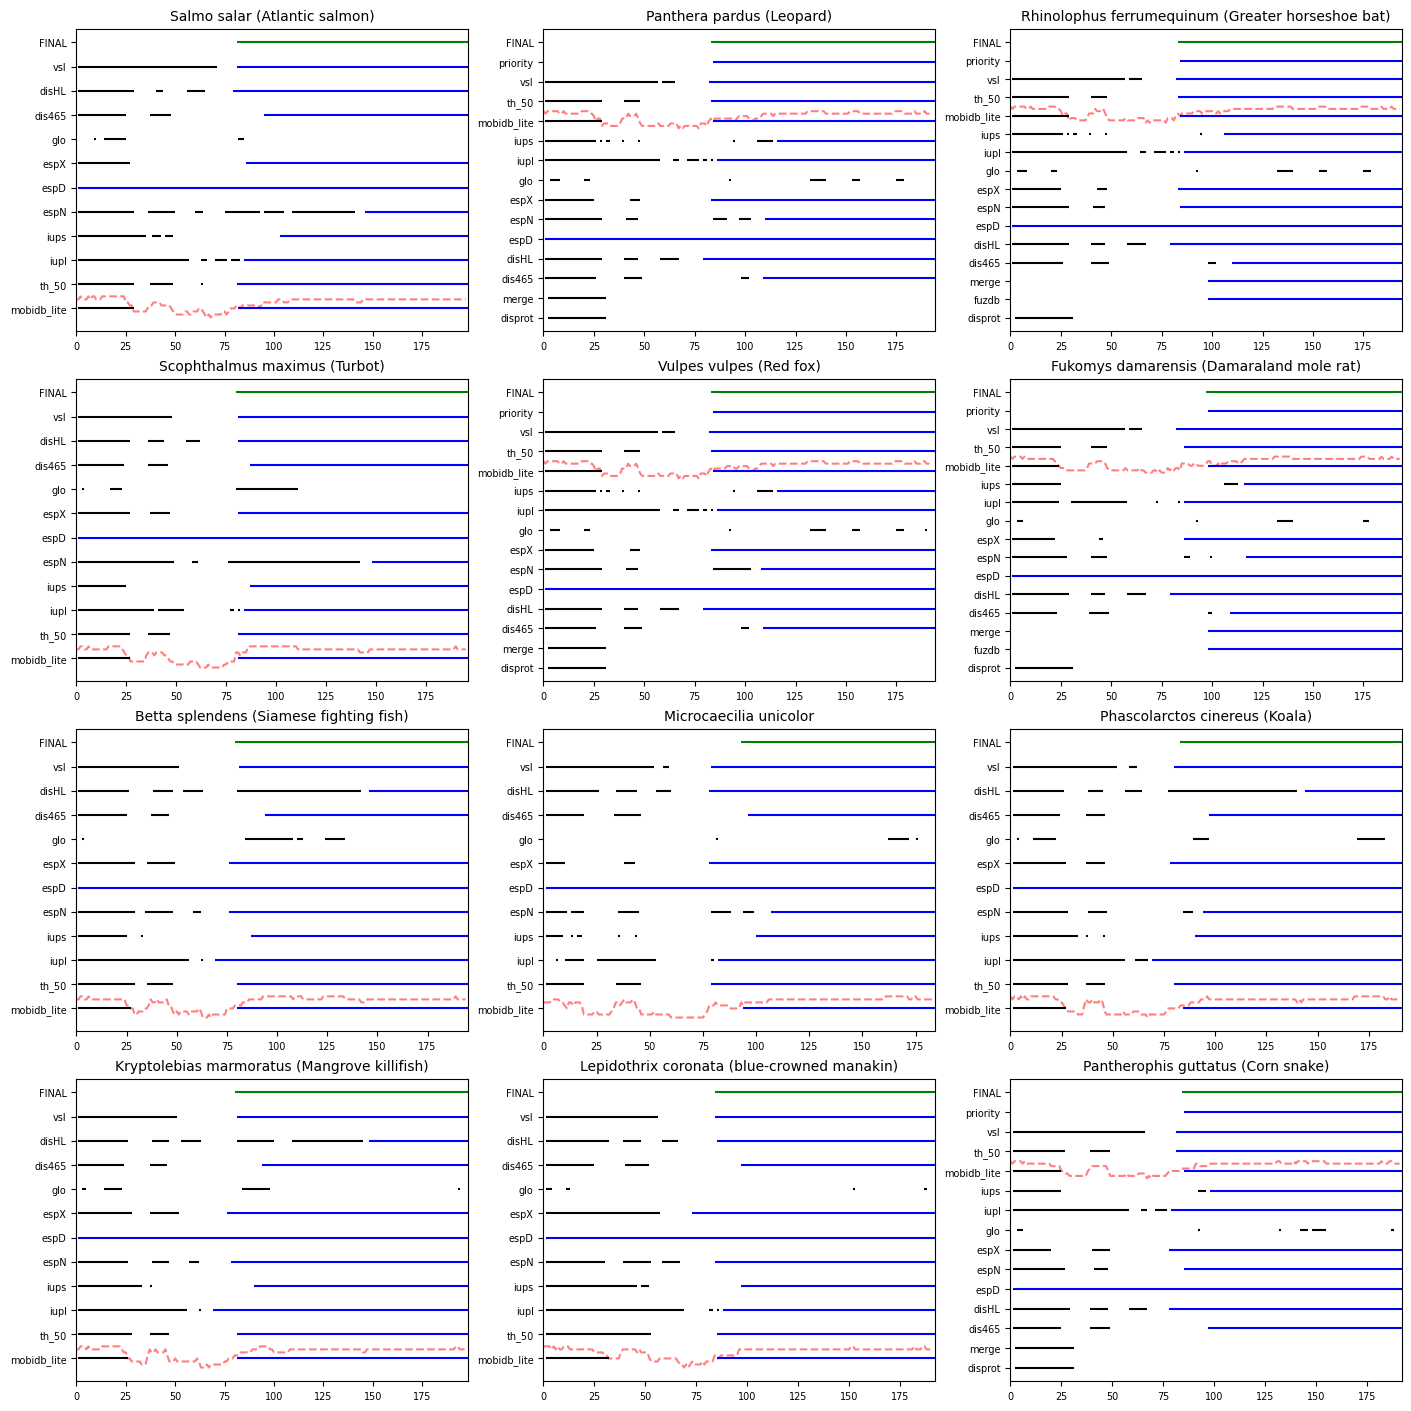

In [ ]:
# Sampling uniprot IDs
metadata = analyse_utils.load_metadata('ortho_h1-0.json')
metadata = metadata.sample(12)
metadata.set_index('uniprot_id', inplace=True, drop=False)
uniprot_ids = metadata.uniprot_id

# Building fig layout
cols = int(np.floor(np.sqrt(len(uniprot_ids))))
rows = len(uniprot_ids)//cols
fig, axes = plt.subplots(rows, cols, constrained_layout=True)

# Looping over uniprot IDs
for i, uid in enumerate(uniprot_ids):
    if rows == 1:
        ax = axes
    elif cols == 1:
        ax = axes[i]
    else:
        ax = axes[i%rows,i//rows]

    # Querying MobiDB
    response = requests.get(f"https://mobidb.org/api/download", params={'acc': [uid]}).json()
    disorder_regions = {k.split('-')[-1]: response[k]['regions'] for k in response if 'disorder' in k and 'regions' in response[k]}
    disorder_scores = {k.split('-')[-1]: response[k]['scores'] for k in response if 'disorder' in k and 'scores' in response[k]}

    # Plotting MobiDB data
    for j, k in enumerate(disorder_regions):
        # Plotting scores
        if k in disorder_scores:
            ax.plot(range(len(response['sequence'])), [v-0.5+j for v in disorder_scores[k]], 'r--', alpha=0.5)
        # Plotting predicted IDRs
        for region in disorder_regions[k]:
            start, end = region

            # Painting C-terminal IDRs
            if end == len(response['sequence']):
                c = 'b'
            else:
                c = 'k'
                
            ax.hlines(j, start, end, c)

    # Plotting annoted region
    start, end = metadata.location[uid].split(':')
    ax.hlines(len(disorder_regions), int(start), int(end), 'g')

    # Setting labels
    ax.set_xlim(0, len(response['sequence']))
    ax.set_yticks(range(len(disorder_regions)+1))
    ax.set_yticklabels([*disorder_regions.keys(), 'FINAL'])
    ax.tick_params(labelsize=7)
    ax.set_title(metadata.loc[uid,'species'], size=10)

fig.set_size_inches(14, 14)
fig.show()

## Analysis

In [2]:
# Loading metadata
metadata = analyse_utils.load_metadata('ortho_h1-0.json')
metadata

,template,sequence,location,region,variant,description,name,species,uniprot_id
0_AUSLI,0_AUSLI,HTKGIGASGSFRLTKPEDSSKKPAKAAAAVAAKPKKVAKAKPKKAA...,80:197,CTD,Wild type,histone H1.0-B,A0A2I4B7C3_AUSLI,Austrofundulus limnaeus (Annual killifish),A0A2I4B7C3
1_CYPVA,1_CYPVA,RHTKGIGASGSFRLTKPEDTKKPAAKAASAPKPKKVVKPKPKKAAK...,78:194,CTD,Wild type,Histone H1.0-B,A0A3Q2C803_CYPVA,Cyprinodon variegatus (Sheepshead minnow),A0A3Q2C803
2_FUNHE,2_FUNHE,RHTKGIGASGSFRLTKPEDTKKTPAKAASAAKPRKVAKPKPKKAAK...,79:195,CTD,Wild type,Histone H1.0-B,A0A3Q2Q6G9_FUNHE,Fundulus heteroclitus (Killifish),A0A3Q2Q6G9
3_KRYMA,3_KRYMA,HTKGIGASGSFRLTKPEDSSKKPAKAAAAAASAKPKKVAKPKPKKA...,80:198,CTD,Wild type,Histone H1.0-B,A0A3Q3AJ14_KRYMA,Kryptolebias marmoratus (Mangrove killifish),A0A3Q3AJ14
4_NOTFU,4_NOTFU,RHTKGIGASGSFRLTKPEDSKKPAKAAASAKPKKVAKPKPKKAAKP...,79:194,CTD,Wild type,"H1 histone family, member 0",A0A1A8V9N7_NOTFU,Nothobranchius furzeri (Turquoise killifish),A0A1A8V9N7
...,...,...,...,...,...,...,...,...,...
190_NECAM,190_NECAM,RKEVVRKEAAQKAKPTRNTTGSSSRKTVKSVKKSTASRV,168:207,CTD,Wild type,Linker histone H1 and H5 family protein,W2TEX0_NECAM,Necator americanus (Human hookworm),W2TEX0
191_STRRB,191_STRRB,KKSSEAKKVTDSKKSTDVKKTPETKKAVKAPKAKATEKKVLKKAIV...,138:221,CTD,Wild type,Histone H1.0,A0A090KXU4_STRRB,Strongyloides ratti (Parasitic roundworm),A0A090KXU4
192_CAPO3,192_CAPO3,AAALPKAAKAPKAAKAPKAEKPAKAAKAPKADKPAKAAKAPKAAKA...,213:355,CTD,Wild type,H15 domain-containing protein,A0A0D2VKG3_CAPO3,Capsaspora owczarzaki (strain ATCC 30864),A0A0D2VKG3
193_STRPU,193_STRPU,RHVKGSGASGSFLLAEKTKTPKKAAAKKATPKKKPAAKKTKKPAAK...,89:185,CTD,Wild type,Histone H1-delta,H1D_STRPU,Strongylocentrotus purpuratus (Purple sea urchin),P15870


In [3]:
# Loading trajectories
metadata['traj'] = metadata.apply(lambda row: md.load_dcd(*['/'.join(['results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

In [16]:
# Unpickling analysis checkpoint
analysis = pd.read_pickle("results/analysis.pkl")
metadata = analysis[['template', 'sequence', 'location', 'region', 'variant', 'uniprot_id', 'name', 'description', 'species', 'traj']]
cider = analysis[['kappa', 'FCR', 'NCPR', 'Hydrophobicity', 'Frac. dis. prom.', 'Length', 'Charge']]
freqs = analysis[['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']]
struc = analysis[['Rg', '<Rg>', 'Re', '<Re>', 'Delta', '<Delta>','S', '<S>', 'v', 'outlier']]

In [62]:
# Pickling analysis checkpoint
analysis = pd.concat([metadata, cider, freqs, struc], axis=1)
analysis.to_pickle("results/analysis.pkl")

### Sequence characteristics

#### CIDER parameters

In [4]:
# Calculating parameters
cider = analyse_utils.cider_parameters(metadata.sequence)
cider['Length'] = metadata.sequence.str.len()
cider['Charge'] = (cider.Length * cider.NCPR).astype(int)

cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.,Length,Charge
0_AUSLI,0.158457,0.418803,0.367521,3.322222,0.923077,117,43
1_CYPVA,0.148615,0.431034,0.379310,3.207759,0.922414,116,44
2_FUNHE,0.148615,0.431034,0.379310,3.225862,0.922414,116,44
3_KRYMA,0.162442,0.415254,0.364407,3.280508,0.923729,118,43
4_NOTFU,0.149631,0.434783,0.382609,3.166087,0.939130,115,44
...,...,...,...,...,...,...,...
190_NECAM,0.140104,0.384615,0.282051,3.223077,0.846154,39,11
191_STRRB,0.130722,0.469880,0.301205,3.260241,0.855422,83,25
192_CAPO3,0.091084,0.394366,0.253521,3.490141,0.978873,142,36
193_STRPU,0.149019,0.427083,0.406250,3.317708,0.916667,96,39


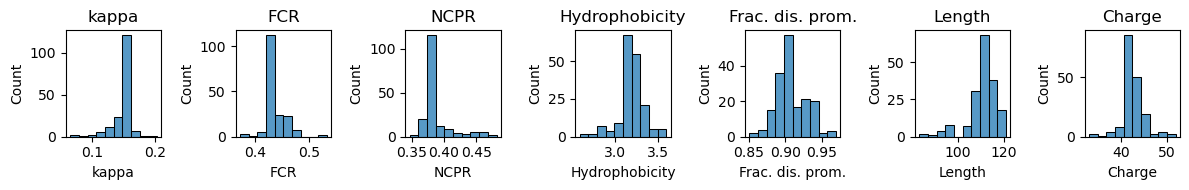

In [83]:
# Plotting CIDER parameters distribution
fig, axes = plt.subplots(ncols=len(cider.columns), figsize=(12,2))

# Looping over subplots and parameters
for ax, col in zip(axes, cider.columns):
    sns.histplot(data=cider, x=col, bins=10, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

#### Amino acid content

In [5]:
# Calculating frequencies
freqs = analyse_utils.amino_acid_content(metadata.sequence)

freqs

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0_AUSLI,0.247863,0.0,0.008547,0.017094,0.008547,0.025641,0.008547,0.008547,0.384615,0.008547,0.000000,0.000000,0.119658,0.000000,0.008547,0.051282,0.051282,0.051282,0.0,0.0
1_CYPVA,0.224138,0.0,0.008621,0.017241,0.008621,0.025862,0.008621,0.008621,0.387931,0.008621,0.000000,0.000000,0.137931,0.000000,0.017241,0.025862,0.068966,0.051724,0.0,0.0
2_FUNHE,0.232759,0.0,0.008621,0.017241,0.008621,0.025862,0.008621,0.008621,0.370690,0.008621,0.000000,0.000000,0.129310,0.000000,0.034483,0.034483,0.060345,0.051724,0.0,0.0
3_KRYMA,0.237288,0.0,0.008475,0.016949,0.008475,0.033898,0.008475,0.008475,0.381356,0.008475,0.008475,0.000000,0.127119,0.000000,0.008475,0.050847,0.050847,0.042373,0.0,0.0
4_NOTFU,0.243478,0.0,0.008696,0.017391,0.008696,0.026087,0.008696,0.008696,0.391304,0.008696,0.000000,0.000000,0.130435,0.000000,0.017391,0.052174,0.043478,0.034783,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190_NECAM,0.102564,0.0,0.000000,0.051282,0.000000,0.025641,0.000000,0.000000,0.205128,0.000000,0.000000,0.025641,0.025641,0.025641,0.128205,0.153846,0.128205,0.128205,0.0,0.0
191_STRRB,0.144578,0.0,0.048193,0.036145,0.000000,0.000000,0.000000,0.012048,0.385542,0.024096,0.000000,0.012048,0.036145,0.000000,0.000000,0.084337,0.120482,0.096386,0.0,0.0
192_CAPO3,0.394366,0.0,0.028169,0.042254,0.000000,0.000000,0.000000,0.007042,0.323944,0.007042,0.000000,0.000000,0.183099,0.000000,0.000000,0.000000,0.007042,0.007042,0.0,0.0
193_STRPU,0.239583,0.0,0.000000,0.010417,0.010417,0.052083,0.010417,0.000000,0.406250,0.020833,0.000000,0.000000,0.093750,0.000000,0.010417,0.031250,0.062500,0.052083,0.0,0.0


In [79]:
# Calculating average number of AAs
pd.DataFrame(freqs.mean() * cider.Length.mean()).transpose()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,21.127187,0.007574,0.984508,2.125012,1.336617,3.36168,0.228361,0.463624,41.865737,1.253123,0.075823,0.219161,12.556846,0.395363,3.175819,7.878605,6.194091,6.973222,0.0,0.005161


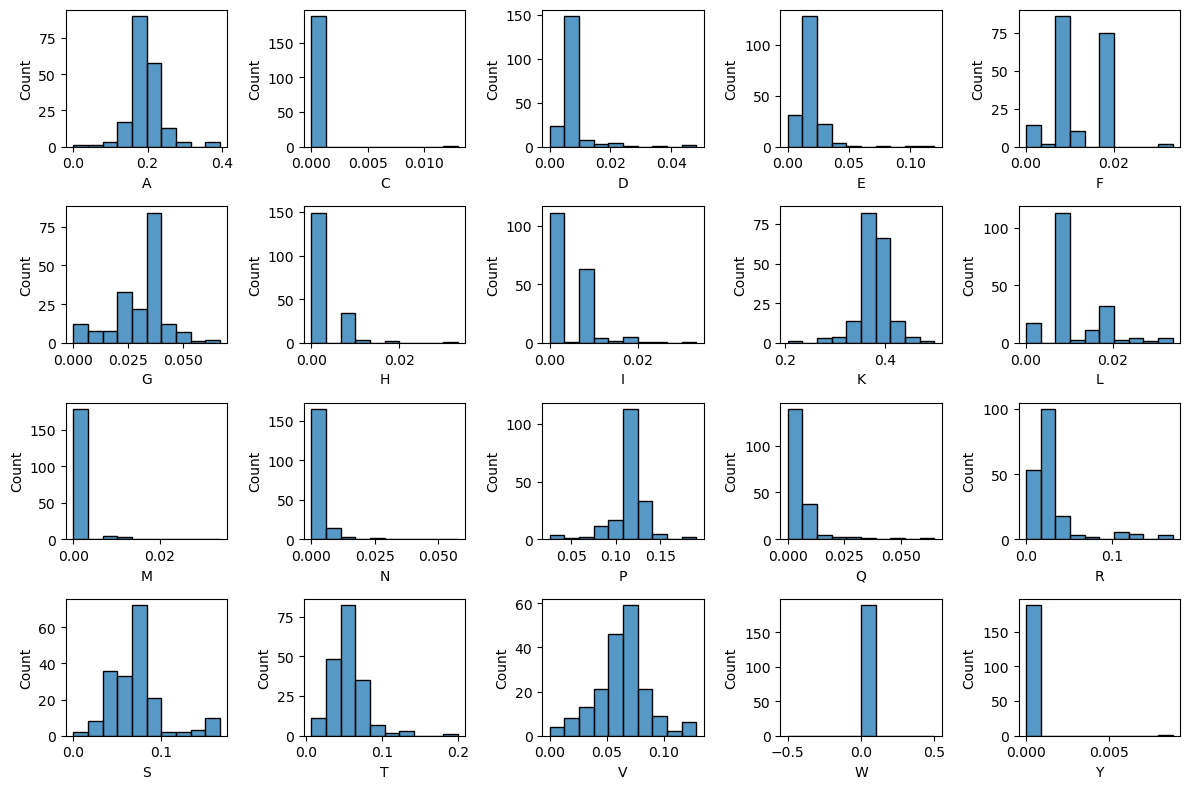

In [101]:
# Plotting distributions
dimensions = (4,5)
fig, axes = plt.subplots(*dimensions, figsize=(12,8))
amino_acids = np.reshape(analyse_utils.amino_acids, dimensions)
for i in range(dimensions[0]):
    for j in range(dimensions[1]):
        ax = axes[i,j]
        aa = amino_acids[i,j]
        sns.histplot(data=freqs, x=aa, bins=10, ax=ax)

plt.tight_layout()
plt.show()

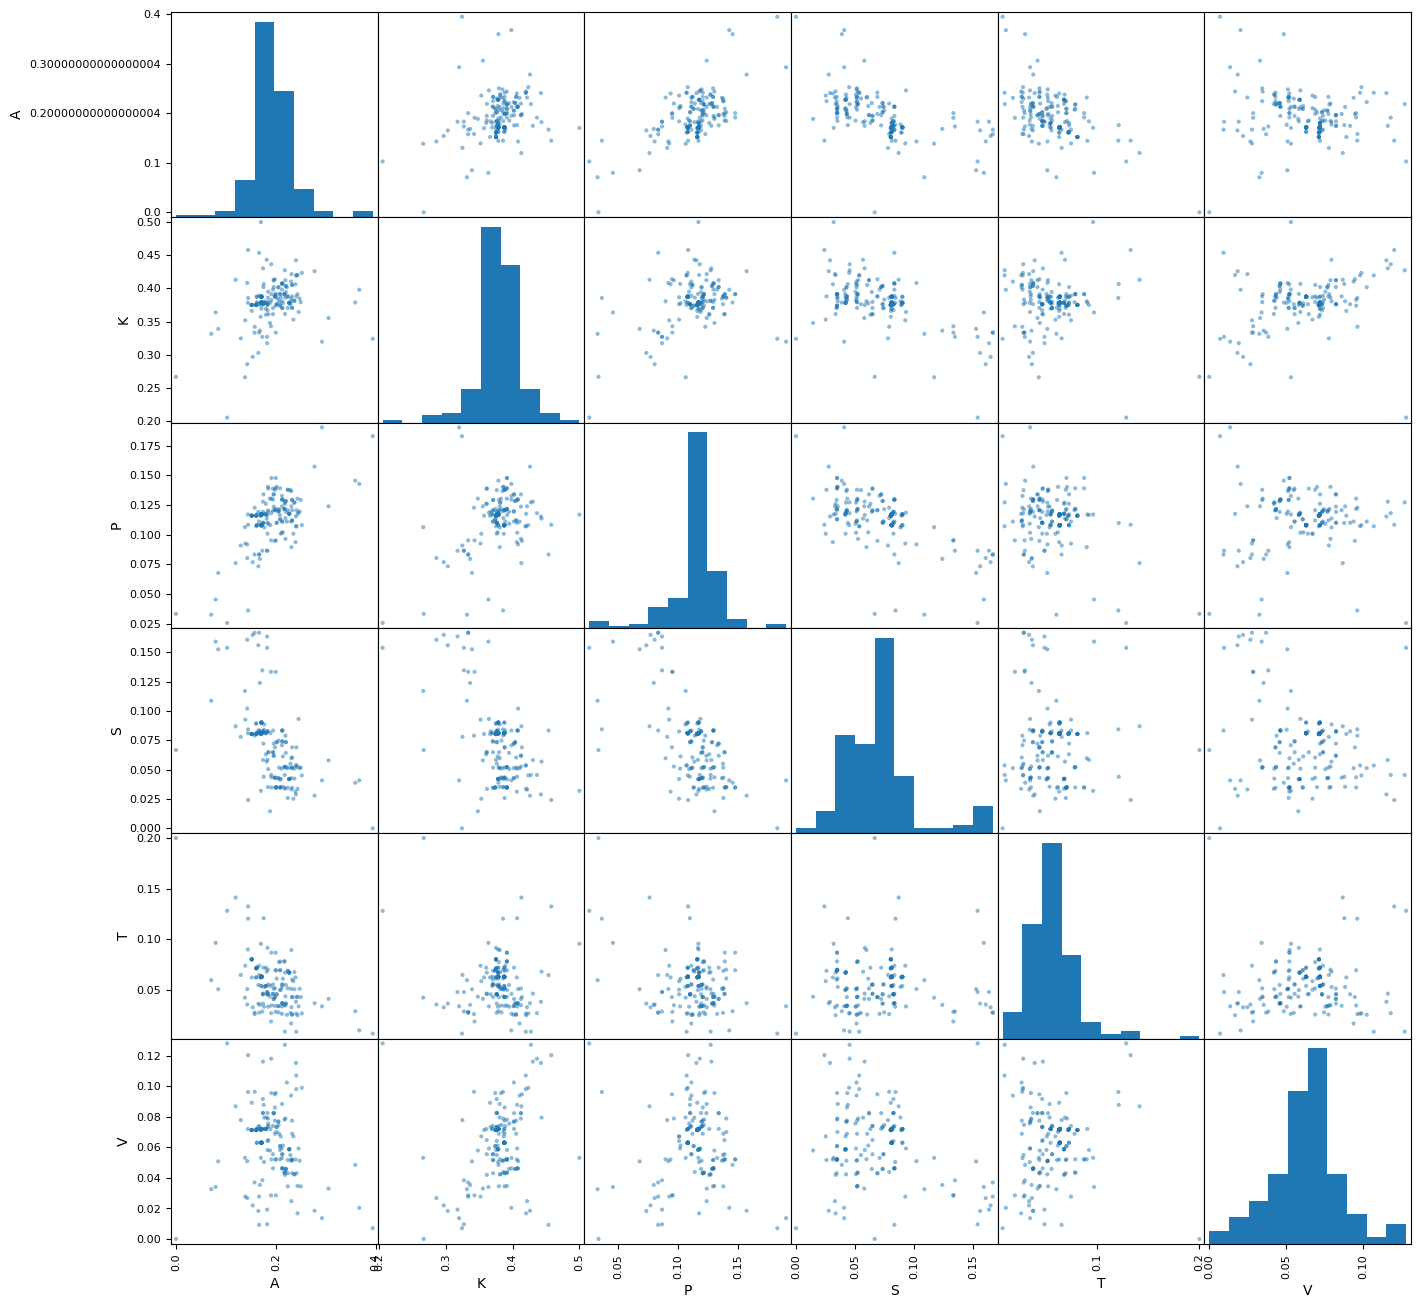

In [6]:
# Plotting a scatter matrix for most common residue types
_ = pd.plotting.scatter_matrix(freqs.loc[:, freqs.mean() > 1/20], figsize=(16, 16))

#### Principal component analysis

In [8]:
# Performing PCA
# Standardising data
features = freqs
features = (features - features.mean()) / features.std()
features.fillna(0, inplace=True)

# Perform PCA
pca = PCA()

# Calculate principal components
pca_pcs = pd.DataFrame(pca.fit_transform(features), columns=[f'PC{i+1}' for i in range(len(features.columns))], index=features.index)

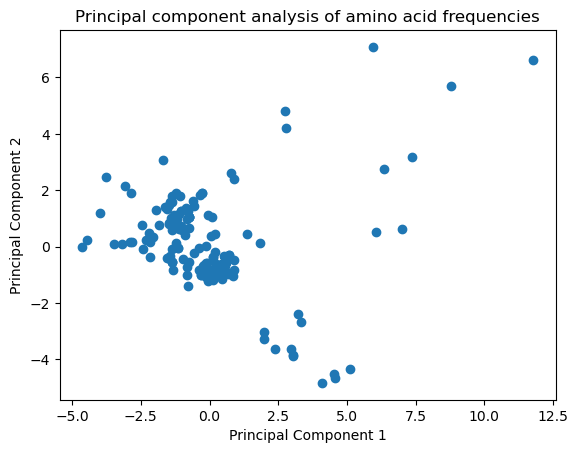

In [30]:
# Plot the first two principal components
plt.scatter(pca_pcs.PC1, pca_pcs.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Principal component analysis of amino acid frequencies")
plt.show()

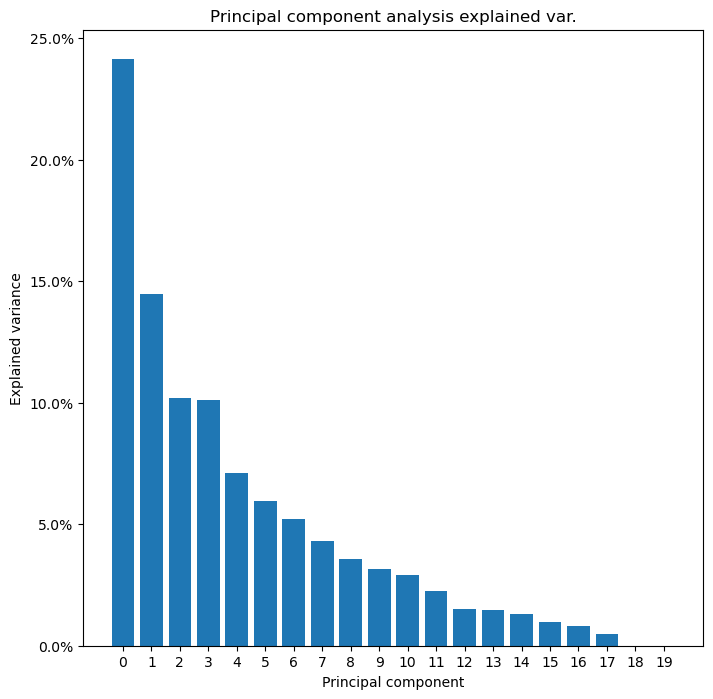

In [ ]:
# Plot the explained variance
plt.bar(range(len(features.columns)), pca.explained_variance_ratio_)
plt.xticks(range(len(features.columns)))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.title('Principal component analysis explained var.')
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

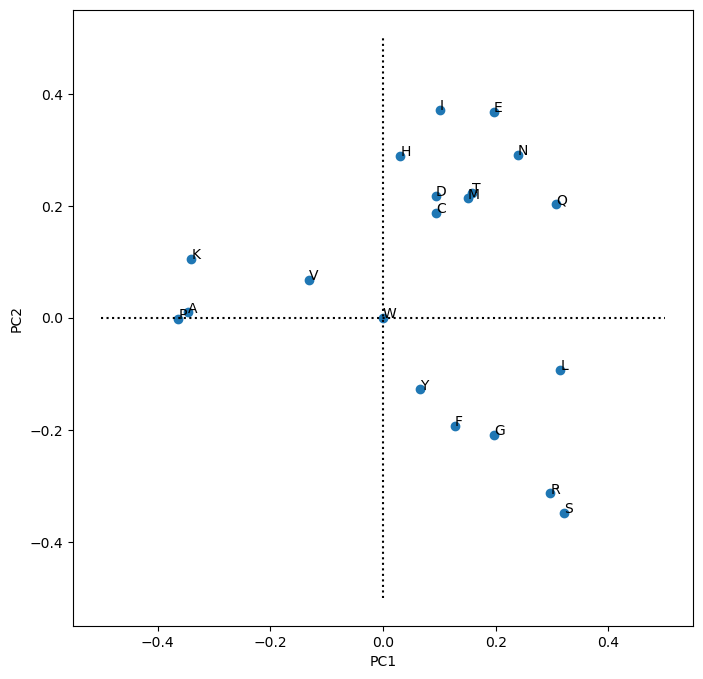

In [ ]:
# Plotting rotational matrix for first two PCs
rotation_matrix = pca.components_.T
fig, ax = plt.subplots()
ax.scatter(rotation_matrix[:,0], rotation_matrix[:,1])
for i, feature_name in enumerate(features.columns):
    ax.annotate(feature_name, (rotation_matrix[i,0], rotation_matrix[i,1]))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.hlines(0,-0.5, 0.5, 'k', 'dotted')
ax.vlines(0,-0.5, 0.5, 'k', 'dotted')
plt.show()

#### Clustering

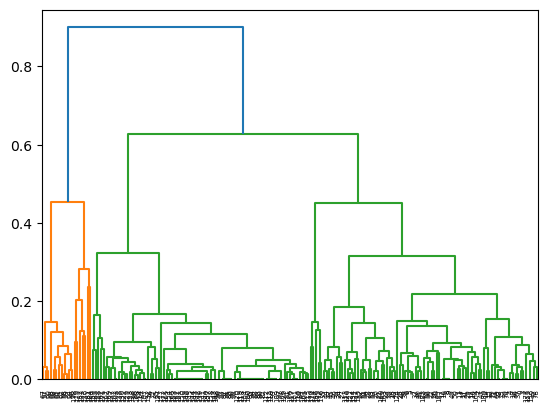

In [14]:
# Hierarchical clustering
linkage_data = linkage(freqs, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

In [21]:
# Assigning labels
n_clusters = 2
clusters = pd.Series(AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(freqs), index=freqs.index)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### Structural descriptors

In [6]:
struc = cider[['Length']]

In [ ]:
# Computing radius of gyration
struc['Rg'] = metadata.apply(lambda row: analyse_utils.compute_rg(row.sequence, row.traj), axis=1)
struc['<Rg>'] = struc.apply(lambda row: row.Rg.mean(), axis=1)

In [ ]:
# Computing end-to-end distance
struc['Re'] = metadata.apply(lambda row: analyse_utils.compute_end_to_end(row.traj), axis=1)
struc['<Re>'] = struc.apply(lambda row: row.Re.mean(), axis=1)

In [ ]:
# Computing asphericity
struc['Delta'] = metadata.apply(lambda row: analyse_utils.compute_asphericity(row.sequence, row.traj), axis=1)
struc['<Delta>'] = struc.apply(lambda row: row.Delta.mean(), axis=1)

In [15]:
# Computing prolateness
struc['S'] = metadata.apply(lambda row: analyse_utils.compute_prolateness(row.sequence, row.traj), axis=1)
struc['<S>'] = struc.apply(lambda row: row.S.mean(), axis=1)

In [59]:
# Computing scaling exponent
struc['v'] = metadata.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=0.518, ij_cutoff=10)[0], axis=1)

In [92]:
# Displaying means
struc[[*struc.columns[struc.columns.str.contains('<')], 'v']]

,<Rg>,<Re>,<Delta>,<S>,v
0_AUSLI,4.378730,10.881938,0.200934,0.684332,0.658618
1_CYPVA,4.393882,10.925552,0.201523,0.688194,0.660819
2_FUNHE,4.372147,10.856758,0.196433,0.675185,0.659913
3_KRYMA,4.354709,10.781242,0.197993,0.665543,0.656727
4_NOTFU,4.357506,10.836154,0.199918,0.672768,0.660378
...,...,...,...,...,...
190_NECAM,1.913091,4.744866,0.197675,0.659799,0.617947
191_STRRB,3.350084,8.281954,0.198033,0.671443,0.645854
192_CAPO3,4.498313,11.207869,0.193014,0.616365,0.635291
193_STRPU,3.917712,9.772506,0.204002,0.697546,0.663740


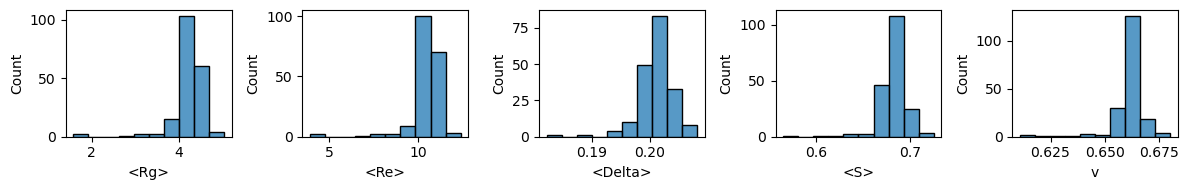

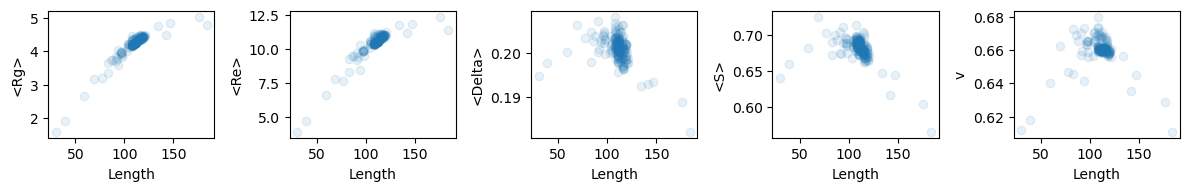

In [38]:
# Plotting descriptor distribution
struc_means = struc[[*struc.columns[struc.columns.str.contains('<')], 'v']]
fig, axes = plt.subplots(ncols=len(struc_means.columns), figsize=(12,2))

# Looping over subplots and descriptors
for ax, col in zip(axes, struc_means.columns):
    sns.histplot(data=struc_means, x=col, bins=10, ax=ax)

plt.tight_layout()
plt.show()



# Plotting descriptor variation with length
fig, axes = plt.subplots(ncols=len(struc_means.columns), figsize=(12,2))

# Looping over subplots and descriptors
for ax, col in zip(axes, struc_means.columns):
    ax.scatter(x=cider.Length, y=struc_means[col], alpha=0.1)
    ax.set_ylabel(col)
    ax.set_xlabel('Length')

plt.tight_layout()
plt.show()

#### Outlier filtering

In [41]:
# Setting outliers by sequence length (75<=L<=125) and scaling exponent (0.65<v)
struc['outlier'] = ~((abs(cider.Length-100)<=25) & (struc.v>0.65))

In [48]:
# Mean values amongst filtered
pd.concat([struc[~struc['outlier']][['<Rg>', '<Re>', '<Delta>', '<S>', 'v']].mean(), cider[~struc['outlier']][['Length']].mean()])

<Rg>         4.257806
<Re>        10.592716
<Delta>      0.201365
<S>          0.683427
v            0.661649
Length     110.728814
dtype: float64

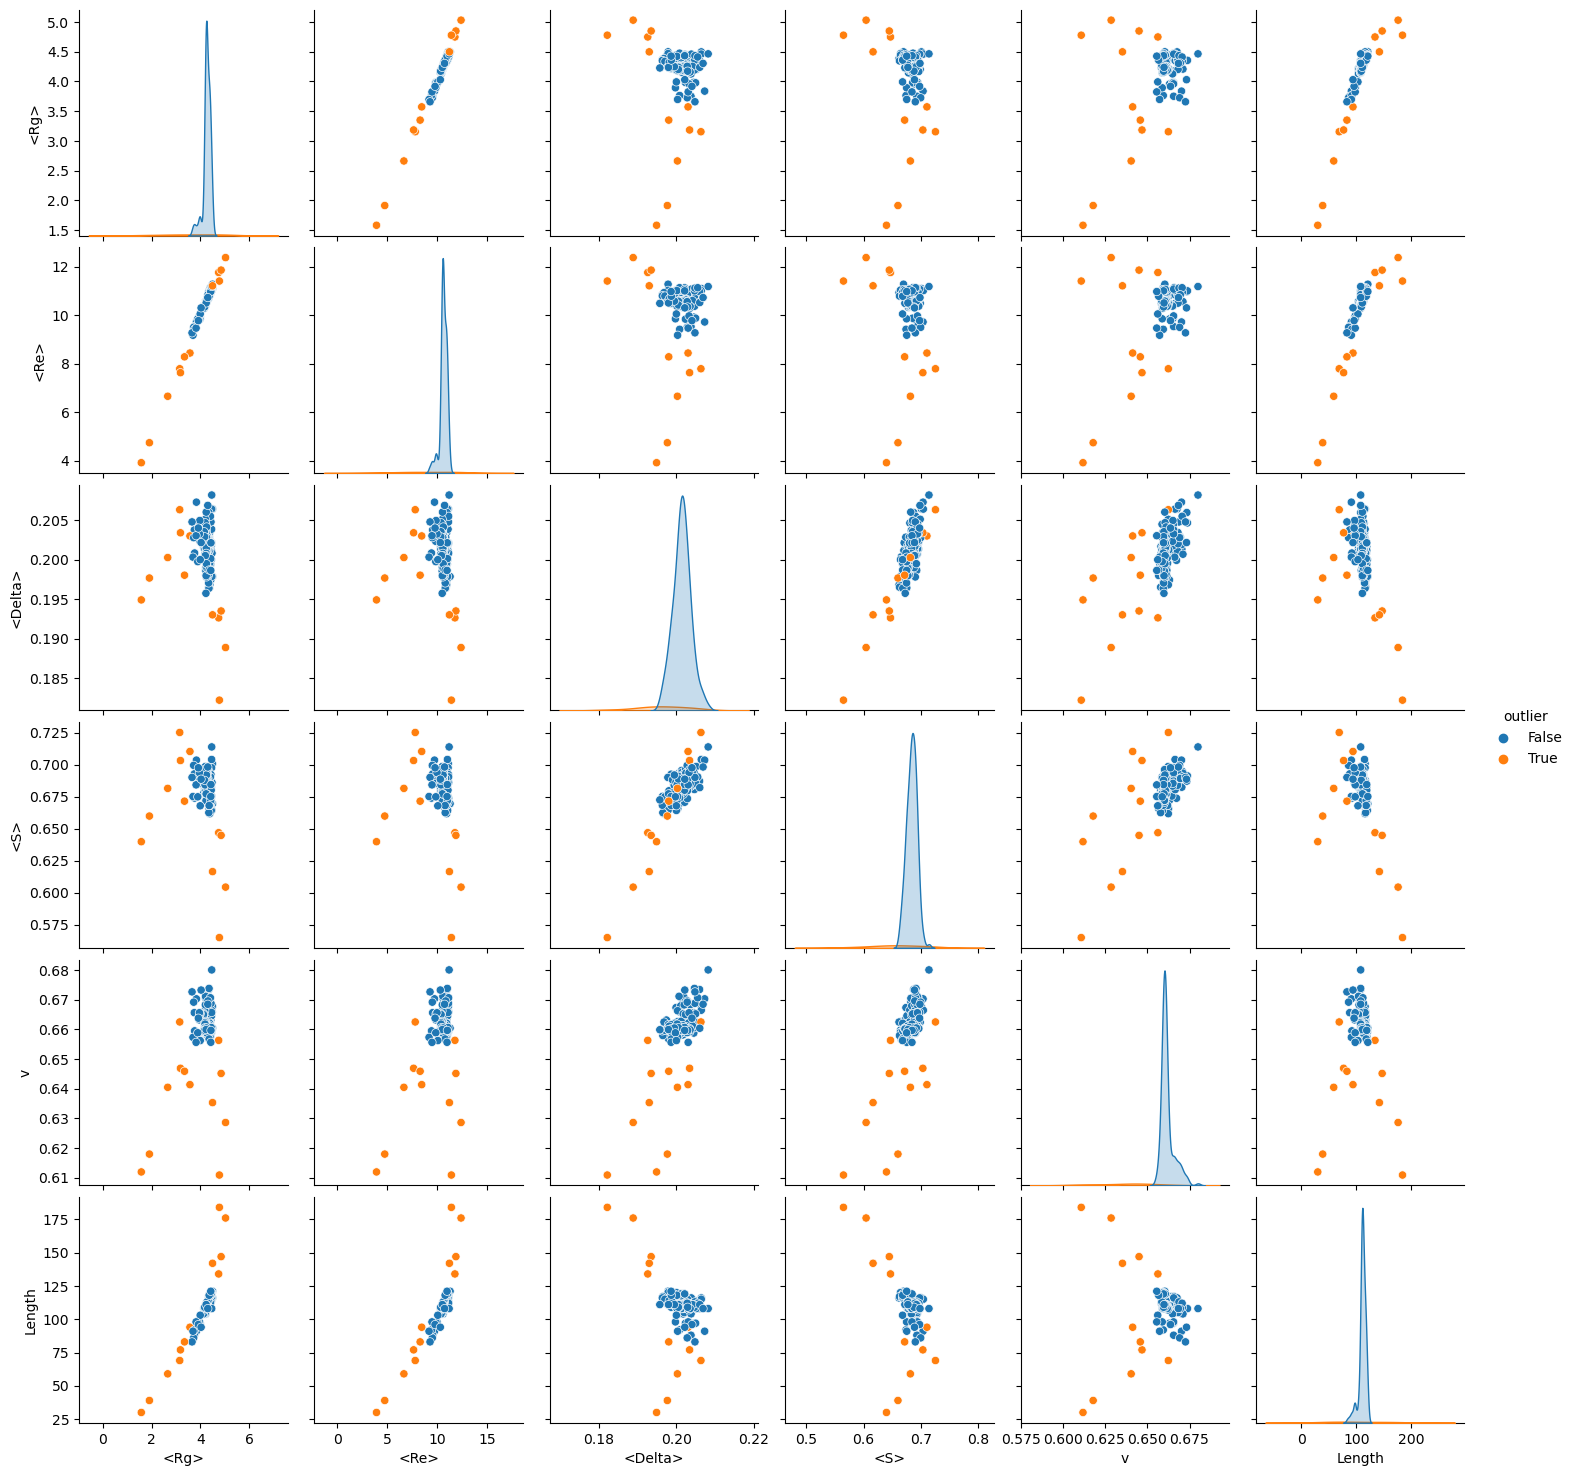

In [51]:
# Plotting distributions
sns.pairplot(pd.concat([struc[['<Rg>', '<Re>', '<Delta>', '<S>', 'v', 'outlier']], cider[['Length']]], axis=1), hue='outlier')

#### Scan of $R_0$ for scaling exponent

The scan is performed using SBATCH

<Axes: >

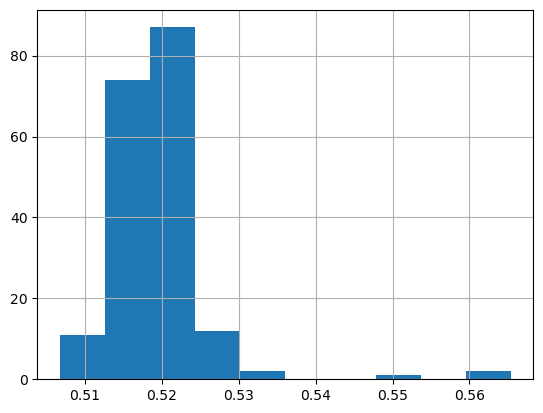

In [51]:
# Determining scan range
fits = metadata.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=None, ij_cutoff=10), axis=1)
fits = pd.concat([fits.explode()[0::4], fits.explode()[2::4]], axis=1)
fits.columns = ['v', 'r0']
fits.r0.hist()

In [81]:
# Loading scan
scan = pd.read_csv("results/r0_scan.csv", index_col=0)
scan.columns = scan.columns.astype(float)
scan

,0.500,0.501,0.502,0.503,0.504,0.505,0.506,0.507,0.508,0.509,...,0.591,0.592,0.593,0.594,0.595,0.596,0.597,0.598,0.599,0.600
id,,,,,,,,,,,,,,,,,,,,,
185_BRUMA,0.116352,0.115513,0.114689,0.113881,0.113088,0.112310,0.111547,0.110799,0.110066,0.109348,...,0.093995,0.094265,0.094544,0.094833,0.095131,0.095438,0.095755,0.096081,0.096416,0.096760
190_NECAM,0.170532,0.169539,0.168589,0.167683,0.166820,0.166001,0.165225,0.164491,0.163800,0.163150,...,0.233635,0.235791,0.237975,0.240185,0.242422,0.244685,0.246974,0.249290,0.251631,0.253998
187_LOALO,0.832709,0.829086,0.825649,0.822397,0.819331,0.816448,0.813748,0.811230,0.808893,0.806735,...,1.159532,1.169419,1.179422,1.189541,1.199774,1.210122,1.220584,1.231159,1.241847,1.252647
126_CRIGR,2.941360,2.936098,2.931149,2.926510,2.922179,2.918155,2.914437,2.911022,2.907909,2.905096,...,3.561093,3.578458,3.596018,3.613772,3.631720,3.649860,3.668191,3.686712,3.705423,3.724323
138_OCTDE,13.183748,13.173716,13.164113,13.154938,13.146188,13.137861,13.129954,13.122466,13.115394,13.108736,...,13.787765,13.809018,13.830543,13.852337,13.874400,13.896730,13.919326,13.942186,13.965310,13.988695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98_DESRO,15.721159,15.700611,15.681211,15.662954,15.645834,15.629844,15.614980,15.601235,15.588604,15.577080,...,17.926215,17.989922,18.054366,18.119542,18.185449,18.252081,18.319436,18.387511,18.456302,18.525805
97_CAPHI,15.635126,15.611013,15.588052,15.566236,15.545562,15.526021,15.507609,15.490320,15.474148,15.459088,...,17.529862,17.590313,17.651504,17.713431,17.776090,17.839480,17.903595,17.968433,18.033990,18.100263
99_ENHLU,16.092618,16.075736,16.059993,16.045385,16.031904,16.019547,16.008306,15.998175,15.989151,15.981226,...,18.599711,18.666417,18.733852,18.802015,18.870901,18.940507,19.010829,19.081864,19.153610,19.226062


Text(0.518, 2475.6180885350486, 'Best $R_0$: 0.518')

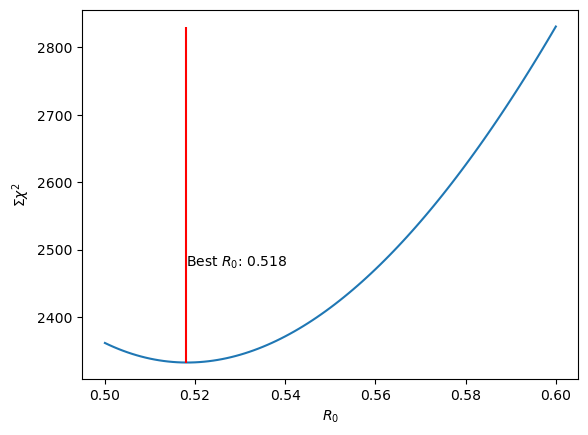

In [90]:
# Finding best R0 value
scan.sum().plot()
best_r0 = float(scan.transpose().loc[scan.sum() == scan.sum().min()].index[0])
plt.vlines(best_r0, scan.sum().min(), scan.sum().max(), color="r")
plt.xlabel("$R_{0}$")
plt.ylabel("$\Sigma\chi^{2}$")
plt.text(best_r0, scan.sum().mean(), f"Best $R_{0}$: {best_r0}")